# Unsupervised Learning with Linear Algebra: Image Compression with SVD

In this blog post, we use a linear algebra method for unsupervised learning with images. We will implement and experiment with compressing an image using singular value decomposition (SVD). To make this simpler for us, the image we will be compressing will be in greyscale.  


## Selecting an Image and Converting it to Greyscale

In order to compress an image using singular value decomposition (SVD), we first need to select one!  

![Phineas and Ferb](https://i.kym-cdn.com/photos/images/facebook/000/944/663/6a7.png)

Below are functions that will allow us to save this image for our usage and convert it to greyscale. 

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import PIL
import urllib

def read_image(url):
    return np.array(PIL.Image.open(urllib.request.urlopen(url)))

def to_greyscale(im):
    return 1 - np.dot(im[...,:3], [0.2989, 0.5870, 0.1140])

As seen through the image comparison below, our functions `read_image` and `to_greyscale` work as anticipated.  

[Text(0.5, 1.0, 'greyscale')]

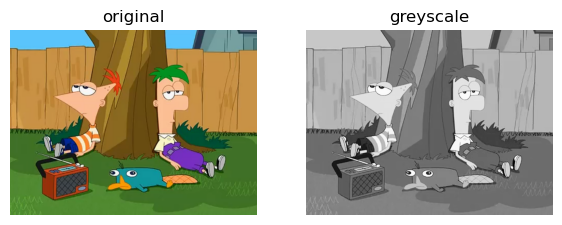

In [2]:
import pathlib

url = "https://i.kym-cdn.com/photos/images/facebook/000/944/663/6a7.png"

img = read_image(url)

fig, axarr = plt.subplots(1, 2, figsize = (7, 3))

grey_img = to_greyscale(img)

axarr[0].imshow(img)
axarr[0].axis("off")
axarr[0].set(title = "original")

axarr[1].imshow(grey_img, cmap = "Greys")
axarr[1].axis("off")
axarr[1].set(title = "greyscale")

## Reconstruct Image Using SVD

### Overview
Recall that the singular value decomposition (SVD) of a matrix 
$\textbf{A} \in \mathbb{R} ^{m x n}$ is 

$$\textbf{A} = \textbf{U} \textbf{D} \textbf{V}^T,$$ 

where 
$\textbf{U} \in \mathbb{R} ^{m x m}$ is an orthogonal matrix, 
$\textbf{D} \in \mathbb{R} ^{m x n}$ has nonzero entries (the singular values $\sigma_i$) only along its diagonal, and 
$\textbf{V} \in \mathbb{R} ^{n x n}$ is an orthogonal matrix.  


Remember that images in greyscale are essentially matrices of *n* by *m* dimensions, where the value at each position represents the darkness of a shade of gray as a number between 0 and 255. Thus, an uncompressed greyscale image would take up $n*m*8$ bits of data.  

In the context of images, SVDs can allow us to compress a greyscale image, so that they take up less space at the risk of losing quality. SVD allows us to factor our image matrix into the $\textbf{U}$, $\textbf{D}$, and $\textbf{V}$ matrices as defined above. By being selective about how many singular values of $\textbf{D}$ we want to use, we can approximate the original matrix of our image with a different matrix that could potentially take up less space. More specifically, if we only wanted to use *k* singular values, then the corresponding image would only take up $(n*k + k + k *m) * 8$ bits of data. The fewer singular values we decide to keep, the more compressed the image will be. By selecting fewer singular values, however, we lose some information about the image, which means that it could become blurrier.  

### Implementing Image Compression

Below we have defined the function `svd_reconstruct` that reconstructs an image from its singular value decomposition (SVD). It requires an image `img` in greyscale as an argument. It also gives one the option to  specify the number of singular values `k` to use. Alternatively, one can specify a desired compression factor `cf`, which is the number of bits required to store the compressed image, divided by the number of bits required to store the original image, or a threshold `epsilon` for the singular values. If one specifies `cf`, the appropriate `k` will be calculated for them, and if one specifies `epsilon` then only the appropriate singular values will be selected for them.  

To calculate the SVD, we use the `np.linalg.svd` method and ensure that our `k` is never larger than *n* or *m*.  

In [3]:
from matplotlib import pyplot as plt
import numpy as np
import warnings 

"""
Given a greyscale image (img) reconstruct the image from its singular value decomposition, 
with the option to specify the number of components (k), a desired compression factor (cf), 
and desired threshold for the singular values (epsilon).
Returns the img as reconstructed matrix. 
"""
def svd_reconstruct(img, k = 10, cf = 0, epsilon = 0):

    # Get height and width from image 
    m, n = img.shape
    
    # Get the img as a 2D matrix 
    data = np.array(img) 

    # Calculate k if given compression factor (cf)
    if (cf != 0):
        k = int((cf * n * m) / (n + m + 1))

    # k is too large for given image
    if ((k > m) or (k > n)):
        warnings.warn("WARNING: k > m or k > n of given image")
        k = min(n, m)
    
    # Compute a singular value decomposition (SVD)
    U, sigma, V = np.linalg.svd(data)

    # create the D matrix in the SVD
    D = np.zeros_like(data, dtype=float) # matrix of zeros of same shape as data
    D[:min(data.shape),:min(data.shape)] = np.diag(sigma) # singular values on the main diagonal

    # User did not specify desired threshold
    if (epsilon == 0): 
        # Approximate by using specified k components
        U_ = U[:,:k] # first k columns of U
        D_ = D[:k, :k] # top k singular values in D
        V_ = V[:k, :] # first k rows of V

    # User specified a threshold 
    else: 
        # Check how many components have a singular value larger than epsilon 
        new_k = np.count_nonzero(D > epsilon)   
        
        
        # Verify that new_k is within reasonable range
        if ((new_k > m) or (new_k > n)):
            new_k = min(n, m)

        # If new_k is smaller than specified components, use new_k specified components 
        if (new_k < k):
            k = new_k
            
        U_ = U[:,:k] # first k columns of U
        D_ = D[:k, :k] # top k singular values in D
        V_ = V[:k, :] # first k rows of V 
        

    # Reconstruct and compute approximation of data
    data_ = U_ @ D_ @ V_
    
    # Compute amount of storage the compressed image takes up
    storage = (n * k) + k + (k * m)
    fraction = storage / (n * m) 
    
    return data_, round(fraction * 100, 2)

### Experiments 

Before we run our experiments, we define a `compare_svd_reconstruct` function that will allow us to more easily see the differences between the original image and a compressed image. This function takes in a greyscale image `img` and optional arguments that will be passed to `svd_reconstruct`. 

In [4]:
"""
Given an image in greyscale (img), compare it to 
the compressed image using the provided optional 
arguments number of singular values (k), compression factor (cf), 
and threshold of singular values (epsilon). 
"""
def compare_svd_reconstruct(img, k = 10, cf = 0, epsilon = 0):
    A = np.array(img)
    A_, storage_percent = svd_reconstruct(A, k, cf = cf, epsilon = epsilon)
    m, n = A.shape
    
    fig, axarr = plt.subplots(1, 2, figsize = (7, 3))

    axarr[0].imshow(A, cmap = "Greys")
    axarr[0].axis("off")
    axarr[0].set(title = "original image")

    axarr[1].imshow(A_, cmap = "Greys")
    axarr[1].axis("off")
    img_title = "reconstructed image\n" + str(storage_percent) + "% storage"
    axarr[1].set(title = img_title)
    
    fig.tight_layout()

Let's see how it does when it only looks at 5 singular values of $\textbf{D}$. 

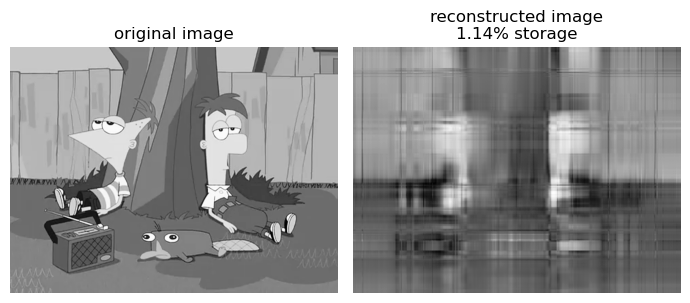

In [5]:
compare_svd_reconstruct(to_greyscale(img), 5)

As discussed earlier, we see that when one selects a "small" number of singular values to use (`k`), the compressed image doesn't take up much space. We see here that while it only takes up 1.14% of the original image, the quality of this image is so low to the point where we can't really make out what the original image was.  

Now let's run an experiment and reconstruct our image with several different values of `k`. Our choice of `k` will go up until we can't distinguish the reconstructed image from the original by eye.

In [6]:
"""
Perform an experiment that reconstructs greyscale image (img) with several different values of k.
"""  
def svd_experiment(img):
    rows = 3
    columns = 4
    fig, axarr = plt.subplots(rows, columns) 

    for i in range(rows):
        for j in range(columns):
            k = (i * 4 + j + 1) * 10
            A_, storage_percent = svd_reconstruct(img, k)
            img_title = str(k) + " components\n" + str(storage_percent) + "% storage"
            axarr[i][j].imshow(A_, cmap="Greys")
            axarr[i][j].axis("off")
            axarr[i][j].set(title=img_title)

    fig.tight_layout()

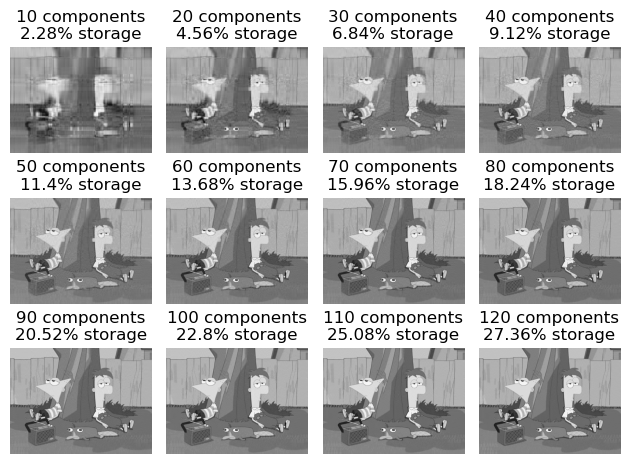

In [7]:
svd_experiment(to_greyscale(img))
plt.savefig('experiment.png')

Our final experiment was when `k` is 120, so let's see how that compares to our original image. 

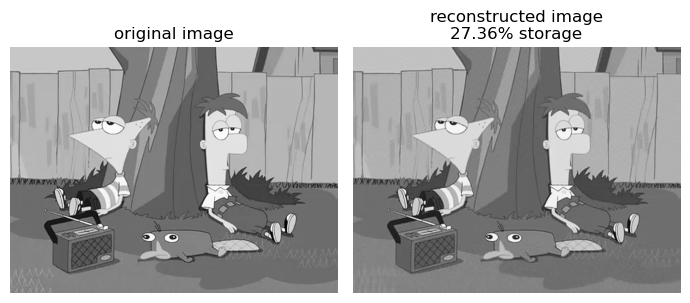

In [8]:
compare_svd_reconstruct(to_greyscale(img), 120)

Based on this experiment, its pretty difficult to distinguish which image is the original and which one is reconstructed. Yet we see that the compressed image still saves us a lot of storage.  

However, it is not always the case that SVDs use less storage than the original image. If we continue to experiment with the other arguments of `svd_reconstruct`, we see that when SVD uses all the singular values along the diagonal of $\textbf{D}$, meaning that $\textbf{U}$ or $\textbf{V}$ is at least as large as the original matrix, the reconstructed image actually takes up more space than the original image. 

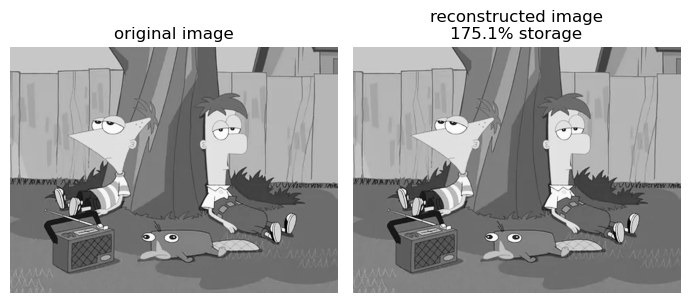

In [9]:
compare_svd_reconstruct(to_greyscale(img), k = min(img.shape[0], img.shape[1]))